In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx, LSTM, TCN, NHITS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

c:\Users\jcyx1\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-24 14:29:58,125	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-24 14:29:58,229	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Preprocessing 

In [ ]:
# First define the tickers that we wish to forecast volatility for, in this example we will look at 2 stocks AAPL and MSFT
# Manually change the ticker list here to forecast multiple stocks simulataneously
tickers = ['AAPL', 'MSFT']

# You can specify the period you wish to consider
start_date = '2009-05-01'
end_date = '2024-10-30'


In [3]:
import yfinance as yf
from arch import arch_model

# Compile our list of dataframes for each ticker that we will concatenate later
ticker_dataframes = []

for ticker in tickers:
    # Fetch the data from yfinance and calculate the log returns based on the Adjusted close price
    ticker_data = yf.download(ticker, start_date, end_date)
    ticker_data = ticker_data[('Adj Close', ticker)].rename('y').to_frame() #Remove the multi-index from the yf download
    ticker_data.index = ticker_data.index.normalize() #normalize to remove time components
    log_returns = np.log(ticker_data['y']/ticker_data['y'].shift(1))[1:] * 10 #Multiply by 10 here for better paramter estimation for GARCH later on
 
    # We calculate the rolling standard deviation over a 5 day rolling window and annualize it 
    volatilities = log_returns.rolling(window=5).std() * np.sqrt(252)
    volatilities = pd.DataFrame(volatilities) 
    volatilities = volatilities.dropna()

    # We add our first exogenous variable VIX as part of our dataframe
    vix_data = yf.download('^VIX', start = volatilities.index.min(), end = end_date)
    vix_values = vix_data[('Adj Close', '^VIX')].values
    volatilities['VIX'] = vix_values

    #We then add our GARCH estimates as our second exogenous variable
    model = arch_model(volatilities['y'], vol='Garch', p=1, q=1, mean='Constant', dist='normal')
    fitted_model = model.fit(disp = 'off')
    conditional_variances = fitted_model.conditional_volatility  # Extract conditional variances (in-sample GARCH values)
    volatilities['GARCH'] = conditional_variances
    
    # We need to get our dataframe into the required format for input later on 
    volatilities['unique_id'] = ticker # Set the unique_id as part of the input requirements
    volatilities = volatilities.reset_index().rename(columns={'Date': 'ds'}) # Reset the index to get it into the specified format of a dataframe in long format 

    ticker_dataframes.append(volatilities)

# We then concatenate all our dataframes by row 
actual_data = pd.concat(ticker_dataframes, axis=0, ignore_index=True)
actual_data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,ds,y,VIX,GARCH,unique_id
0,2009-05-08 00:00:00+00:00,3.603101,32.049999,1.585783,AAPL
1,2009-05-11 00:00:00+00:00,2.030499,32.869999,1.633195,AAPL
2,2009-05-12 00:00:00+00:00,3.091376,31.799999,0.782392,AAPL
3,2009-05-13 00:00:00+00:00,3.409268,33.650002,1.156455,AAPL
4,2009-05-14 00:00:00+00:00,4.784520,31.370001,1.434424,AAPL
...,...,...,...,...,...
7787,2024-10-23 00:00:00+00:00,1.601488,19.240000,0.684941,MSFT
7788,2024-10-24 00:00:00+00:00,1.615035,19.080000,0.576245,MSFT
7789,2024-10-25 00:00:00+00:00,1.641031,20.330000,0.554073,MSFT
7790,2024-10-28 00:00:00+00:00,1.742192,19.799999,0.547940,MSFT


In [36]:
# Splitting 70% of the data as training and 30% of the remaining as test dataset
# We also set the validation length to 10%

train = actual_data.iloc[:int(len(actual_data['y'])*0.7)]
test = actual_data.iloc[int(len(actual_data['y'])*0.7):]
validation_length=int(len(actual_data['y'])*0.7)-int(len(actual_data['y'])*0.6)

test_length= int ((len(actual_data["y"]) / len(tickers))-int(len(actual_data['y']) / len(tickers) * 0.7) )

# Training Process

We refer readers to the Nixtla documentation found at https://nixtlaverse.nixtla.io/neuralforecast/models.html for more information on AutoModels.

Instead of using the default hyperparemeter space, we define our own hyperparameter space bettter suited to our specific task of volatilty forecasting. These have been tested and work
decently well in practice on different stocks on different forecasting horizons. However, feel free to play around with the parameters.

An important paramter here is **num_samples**, which is the number of random configurations that we look at throughout our custom hyperparameter space. Putting a higher number will 
naturally give us a higher chance of finding the best hyper paremeters, but setting it to 20 seems to be optimal both performance and time efficiecncy wise



In [12]:
# We first need to set the forecasting horizon that we wish to forecast. For demonstration, lets try forecasting 3 days forward 
# A note here is that due to the unpredictable nature of volatility, we keep the forecast horizon lower to ensure good forecasting ability of our models
forecast_horizon = 3 #Change this value based on your forecasting needs

In [37]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM, AutoNBEATSx, AutoTCN
from neuralforecast.losses.pytorch import MQLoss

config_nbeatsx = {
    "input_size": tune.choice([21, 63, 84, 126, 189, 252]),         # Number of Lags
    "scaler_type": tune.choice(['robust', 'standard', 'minmax']),   # Scaler Type
    "max_steps": tune.choice([100, 150, 200]),                      # Number of Epochs
    "dropout_prob_theta": tune.choice([0.0, 0.2, 0.4]),             # Dropout Rate
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "n_harmonics": tune.choice([0, 1]),                             # Number of Harmonics
    "n_polynomials": tune.choice([0, 1]),                           # Number of Polynomials
    "stack_types": ['identity', 'identity'],
    "mlp_units": [[512, 512], [512, 512]],                          # Number of units of each hidden layer
    "hist_exog_list" : ['VIX', 'GARCH'], 
    "random_seed" : tune.randint(0,129228148)
}

# # For NBEATSx, the library does not allow us to have "Seasonality" or "Trend" stack types otherwise they collapse into a single value 
# # We therefore define different configurations for the stack types based on the forecast horizon
# if forecast_horizon == 1:
#     config_nbeatsx['stack_types'] = [['identity', 'identity']]
# else:
#     config_nbeatsx['stack_types'] = tune.choice([['identity','identity'],['trend','identity', 'identity'],
#                                                  ['seasonality','identity', 'identity'],['trend','seasonality', 'identity']])  

config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),                    # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                    # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice(['robust', 'standard', 'minmax']),   # Scaler type
    "max_steps": tune.choice([50, 100, 200, 500]),                  # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "hist_exog_list" : ['VIX', 'GARCH'],                                   
    "random_seed" : tune.randint(1,20)
}

config_lstm = {
    "input_size": tune.choice([21, 63, 84, 126, 189, 252]),         # Number of Lags
    "encoder_hidden_size": tune.choice([32, 64, 96, 128, 168]), # Number of Neurons
    "encoder_n_layers": tune.choice([1,2,3,4]),                     # Number of layers in LSTM
    "decoder_hidden_size" : tune.choice([32, 64, 128]),            
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice(['robust', 'standard', 'minmax']),   # Scaler Type
    "max_steps": tune.choice([50,100, 200, 500]),                   # Number of Epochs
    "encoder_dropout": tune.choice([0.0, 0.2, 0.4]),                # Dropout Rate
    # "loss": tune.choice(['MSE', 'MAE', 'Huber Loss']),            # Loss Functions
    "max_steps": tune.choice([50,100, 200, 500]),                   # Number of Epochs
    # "hist_exog_list" : ['GARCH'],
    "hist_exog_list" : ['VIX', 'GARCH'],                                     
    "random_seed" : tune.randint(0,129228148)
}

config_tcn = {
    "input_size": tune.choice([21, 63, 84, 126, 189, 252]),         # Number of Lags
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice(['robust', 'standard', 'minmax']),   # Scaler Type
    "encoder_hidden_size": tune.choice([32, 64, 96, 128, 168]), # Number of Neurons
    'encoder_activation': 'ReLU',
    "decoder_hidden_size" : tune.choice([32, 64, 128]),            
    "max_steps": tune.choice([50,100, 200, 500]),                   # Number of Epoch   
    "kernel_size": tune.choice([2, 3, 4, 6]),                       # Kernel Size
    "dilations": tune.choice([[1, 2], [1, 2, 1], [1, 2, 4], 
                              [1, 2, 4, 1], [1, 1, 2, 2]]),         # Dilations
    "hist_exog_list" : ['VIX', 'GARCH'],                                      
    "random_seed" : tune.randint(0,129228148)
}



In [ ]:
# Initialise the auto models
auto_nbeatsx = AutoNBEATSx(h = forecast_horizon, config = config_nbeatsx, loss = MQLoss(), num_samples = 20)
auto_lstm = AutoLSTM(h = forecast_horizon, config = config_lstm, loss = MQLoss(), num_samples = 20)
auto_nhits = AutoNHITS(h = forecast_horizon, config = config_nhits, loss = MQLoss(), num_samples = 20)
auto_tcn = AutoTCN(h = forecast_horizon, config = config_tcn, loss = MQLoss(), num_samples = 20)

"""
We borrow the API source code from the Nixtla Neural Forecast Library to better explain the parameters that we will use and can be freely adjusted

        `core.NeuralForecast`'s cross-validation efficiently fits a list of NeuralForecast
        models through multiple windows, in either chained or rolled manner.

        Parameters
        ----------
        df : pandas or polars DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If None, a previously stored dataset is required.
        val_size : int, optional (default=None)
            Length of validation size. If passed, set `n_windows=None`.
        static_df : pandas or polars DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`] and static exogenous.
        n_windows : int (default=1)
            Number of windows used for cross validation.
        step_size : int (default=1)
            Step size between each window.
        test_size : int, optional (default=None)
            Length of test size. If passed, set `n_windows=None`.
        refit : bool or int (default=False)
            Retrain model for each cross validation window.
            If False, the models are trained at the beginning and then used to predict each window.
            If positive int, the models are retrained every `refit` windows.
        Returns
        -------
        fcsts_df : pandas or polars DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.
            
Another important detail is the fact that for multiple tickers, the library trains a single model across all time series for efficiency. We can
explicitly use the ID as a feature by setting the parameter "static_features=[your_id_col]""metrics trained on actual data only.png". This may be 
useful if we wish to forecast multiple tickers at one go.

However, if efficiency is not a storng consideraiton, then we may yield better results by simply training a separate model for each ticker individually
"""
        
# In this scenario we set the step_size to 1 (due to restrictions on step_size for recurrent models)
# Regardless, it provides a more robust evlauation as the model is tested across diff regimes
fcst = NeuralForecast(models=[auto_nbeatsx, auto_nhits, auto_lstm, auto_tcn],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=actual_data,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
forecasts = forecasts.dropna()


2024-11-24 17:49:13,554	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/jcyx1/ray_results/_train_tune_2024-11-24_17-44-41' in 0.0215s.
Seed set to 114434144
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MQLoss                     | 5      | eval 
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 112 K  | train
4 | context_adapter | Linear                     | 2.9 K  | train
5 | mlp_decoder     | MLP                        | 2.1 K  | train
-----------------------------------------------------------------------
117 K     Trainable params
5         Non-trainable params
117 K     Total

Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s, v_num=5380, train_loss_step=0.142, train_loss_epoch=0.142]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 35.74it/s, v_num=5380, train_loss_step=0.142, train_loss_epoch=0.142]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.07it/s]


c:\Users\jcyx1\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


# Plotting our forecasts for APPL

In [56]:
# forecasts = forecasts.reset_index('unique_id')
appl_data = forecasts[forecasts['unique_id'] == 'AAPL']
msft_data = forecasts[forecasts['unique_id'] == 'MSFT']

rows_to_select = []
for i in range(0, appl_data.shape[0], forecast_horizon * forecast_horizon):
    for j in range(forecast_horizon):
        rows_to_select.append(i + j)
appl_data = appl_data.iloc[rows_to_select]

rows_to_select = []
for i in range(0, msft_data.shape[0], forecast_horizon * forecast_horizon):
    for j in range(forecast_horizon):
        rows_to_select.append(i + j)
msft_data = msft_data.iloc[rows_to_select]

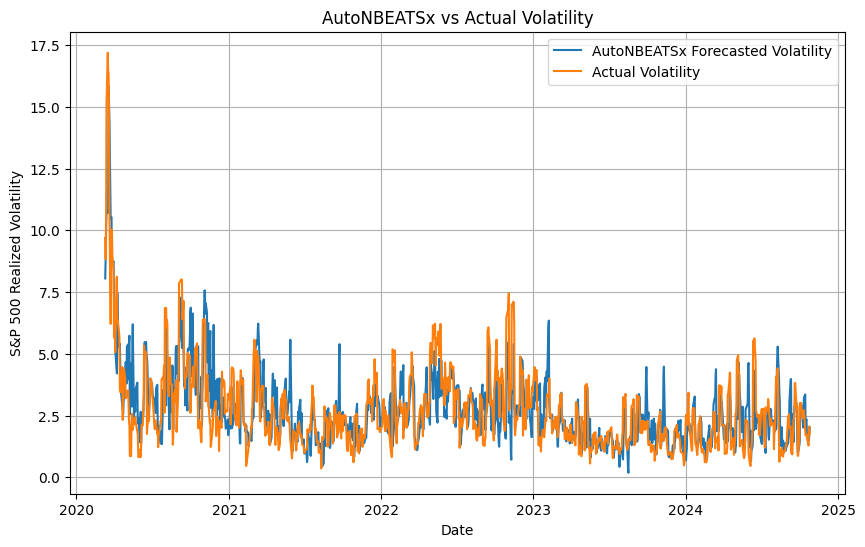

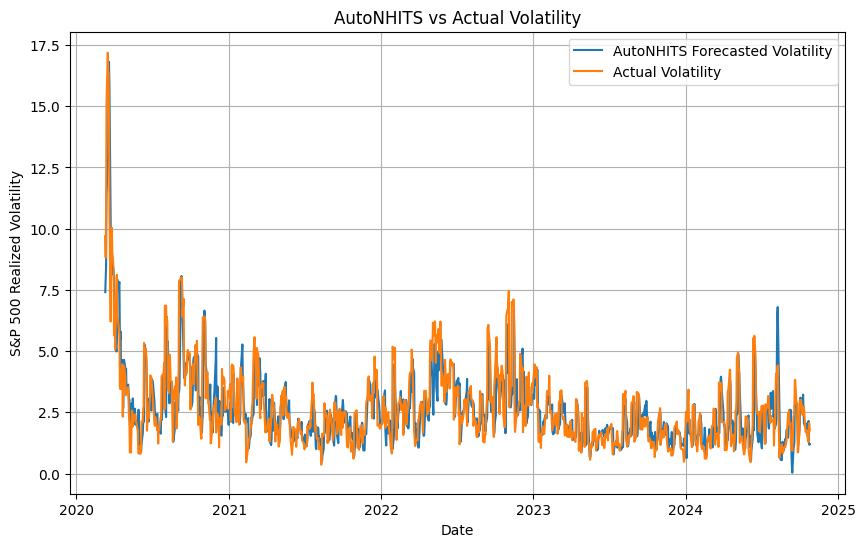

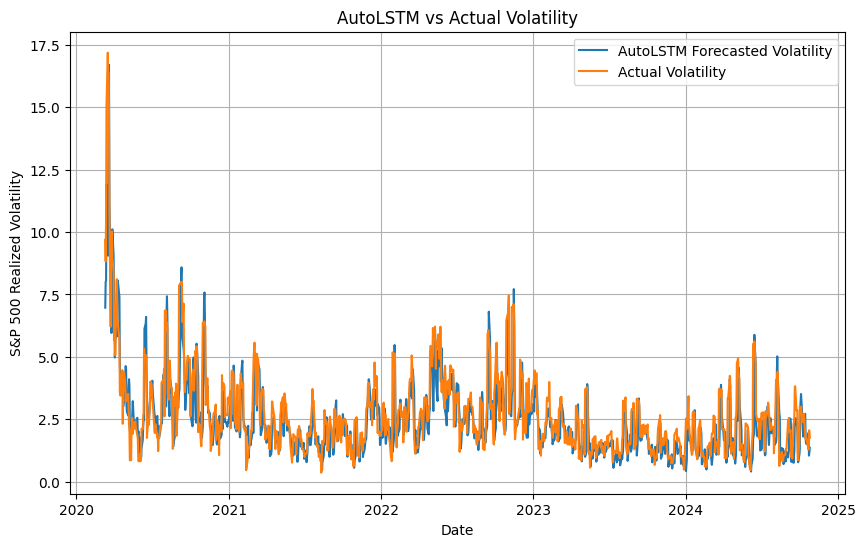

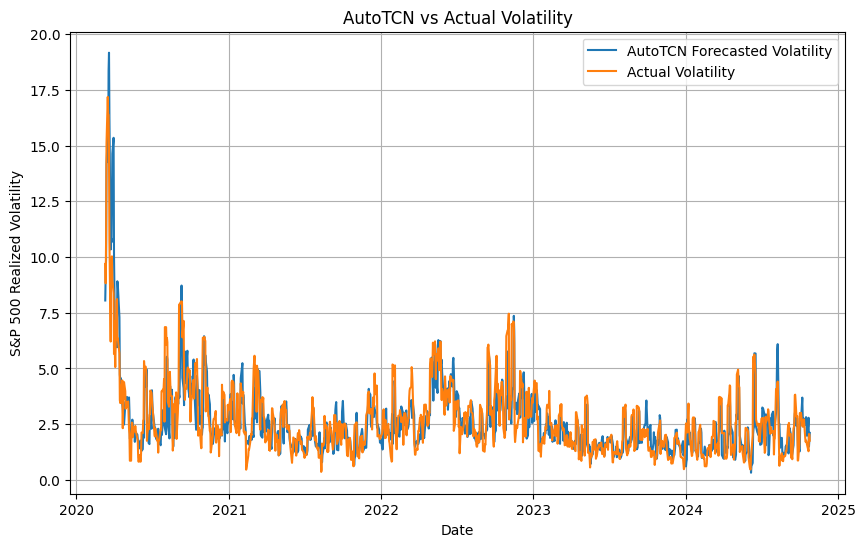

In [ ]:
# Here we plot for the Apple, but the same can be done for other tickers
models = ['AutoNBEATSx', 'AutoNHITS', 'AutoLSTM', 'AutoTCN']  # List of models

# Create subplots for each model
for model in models:
    plt.figure(figsize=(10, 6))
    plt.plot(appl_data["ds"], appl_data[model], label=f"{model} Forecasted Volatility")
    plt.plot(appl_data["ds"], appl_data['y'], label="Actual Volatility")
    plt.ylabel("S&P 500 Realized Volatility")
    plt.xlabel("Date")
    plt.title(f"{model} vs Actual Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluating our models 

In [65]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mse

evaluation_df = evaluate(forecasts.loc[:, forecasts.columns != 'cutoff'], metrics=[rmse, mae, mse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df

,unique_id,metric,AutoNBEATSx,AutoNHITS,AutoLSTM,AutoTCN,best_model
0,AAPL,rmse,1.217331,1.003490,0.969816,1.013210,AutoLSTM
1,MSFT,rmse,1.250400,0.949005,0.944703,0.954864,AutoLSTM
2,AAPL,mae,0.847106,0.673576,0.660016,0.683799,AutoLSTM
3,MSFT,mae,0.796090,0.629759,0.614428,0.648251,AutoLSTM
4,AAPL,mse,1.481894,1.006992,0.940543,1.026595,AutoLSTM
5,MSFT,mse,1.563499,0.900610,0.892464,0.911766,AutoLSTM


# Prediction of all our models

In [ ]:
predictions = fcst.predict()
predictions # We can plot the confidence intervals of 80% and 90% as well

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.30it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 182.00it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.35it/s]


c:\Users\jcyx1\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoNBEATSx-median,AutoNBEATSx-lo-90,AutoNBEATSx-lo-80,AutoNBEATSx-hi-80,AutoNBEATSx-hi-90,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,...,AutoLSTM-median,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90,AutoTCN-median,AutoTCN-lo-90,AutoTCN-lo-80,AutoTCN-hi-80,AutoTCN-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2024-10-30 00:00:00+00:00,1.749788,1.211239,1.330075,2.087604,2.150033,1.855297,1.175960,1.349216,2.279904,...,1.276141,0.685178,0.779657,2.741200,3.286428,1.885025,1.247896,1.393815,2.407517,2.633624
AAPL,2024-10-31 00:00:00+00:00,1.571947,1.115105,1.178271,1.935112,2.037888,1.805048,1.151514,1.169745,2.534449,...,1.604560,0.661520,0.840660,3.547330,4.231465,1.900267,1.188252,1.283536,2.541633,2.763042
AAPL,2024-11-01 00:00:00+00:00,1.431698,0.914582,0.980262,1.840475,1.945400,1.821592,0.957196,1.128692,2.725177,...,1.869959,0.790422,0.950595,4.280246,5.196171,1.828791,1.093582,1.234569,2.433374,2.628284
MSFT,2024-10-30 00:00:00+00:00,1.263265,0.888379,1.035411,1.749051,1.838722,1.317327,0.933909,1.032901,1.693520,...,0.937986,0.444283,0.503749,2.586346,3.258318,1.448488,0.856398,0.946867,2.302764,2.603949
MSFT,2024-10-31 00:00:00+00:00,1.354057,0.902046,0.981258,1.694813,1.830509,1.363895,0.811238,0.958247,1.892561,...,1.361066,0.469009,0.637815,3.516487,4.271449,1.744612,1.015511,1.088613,2.981207,3.450793
MSFT,2024-11-01 00:00:00+00:00,1.259838,0.945837,0.991392,1.736664,1.916025,1.302016,0.768160,0.856001,1.965062,...,1.820318,0.684037,0.890266,4.486790,5.469880,1.811495,0.924795,1.058612,3.203529,3.620988


# Saving our Models

In [68]:
fcst.save(path='./trained_models',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

# Loading our Models

In [69]:
#Load our trained models
fcst2 = NeuralForecast.load(path='./trained_models')

# Sanity check to ensure our predictions are the same
fcst2.predict()

c:\Users\jcyx1\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\common\_base_model.py:444: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  content = to

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.07it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 285.66it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.71it/s]


c:\Users\jcyx1\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralforecast\core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoLSTM-median,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90,AutoNBEATSx-median,AutoNBEATSx-lo-90,AutoNBEATSx-lo-80,AutoNBEATSx-hi-80,...,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoTCN-median,AutoTCN-lo-90,AutoTCN-lo-80,AutoTCN-hi-80,AutoTCN-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2024-10-30 00:00:00+00:00,1.276141,0.685178,0.779657,2.741200,3.286428,1.749788,1.211239,1.330075,2.087604,...,1.855297,1.175960,1.349216,2.279904,2.536136,1.885025,1.247896,1.393815,2.407517,2.633624
AAPL,2024-10-31 00:00:00+00:00,1.604560,0.661520,0.840660,3.547330,4.231465,1.571947,1.115105,1.178271,1.935112,...,1.805048,1.151514,1.169745,2.534449,2.703797,1.900267,1.188252,1.283536,2.541633,2.763042
AAPL,2024-11-01 00:00:00+00:00,1.869959,0.790422,0.950595,4.280246,5.196171,1.431698,0.914582,0.980262,1.840475,...,1.821592,0.957196,1.128692,2.725177,3.012716,1.828791,1.093582,1.234569,2.433374,2.628284
MSFT,2024-10-30 00:00:00+00:00,0.937986,0.444283,0.503749,2.586346,3.258318,1.263265,0.888379,1.035411,1.749051,...,1.317327,0.933909,1.032901,1.693520,1.872649,1.448488,0.856398,0.946867,2.302764,2.603949
MSFT,2024-10-31 00:00:00+00:00,1.361066,0.469009,0.637815,3.516487,4.271449,1.354057,0.902046,0.981258,1.694813,...,1.363895,0.811238,0.958247,1.892561,2.105290,1.744612,1.015511,1.088613,2.981207,3.450793
MSFT,2024-11-01 00:00:00+00:00,1.820318,0.684037,0.890266,4.486790,5.469880,1.259838,0.945837,0.991392,1.736664,...,1.302016,0.768160,0.856001,1.965062,2.173072,1.811495,0.924795,1.058612,3.203529,3.620988
